In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

nifty_50_stocks = [
 'ASIANPAINT.NS',
 'BRITANNIA.NS',
 'CIPLA.NS',
 'EICHERMOT.NS',
 'NESTLEIND.NS',
 'GRASIM.NS',
 'HEROMOTOCO.NS',
 'HINDALCO.NS',
 'HINDUNILVR.NS',
 'ITC.NS',
 'LT.NS',
 'M&M.NS',
 'RELIANCE.NS',
 'TATACONSUM.NS',
 'TATAMOTORS.NS',
 'TATASTEEL.NS',
 'WIPRO.NS',
 'APOLLOHOSP.NS',
 'DRREDDY.NS',
 'TITAN.NS',
 'SBIN.NS',
 'SHRIRAMFIN.NS',
 'BPCL.NS',
 'KOTAKBANK.NS',
 'INFY.NS',
 'BAJFINANCE.NS',
 'ADANIENT.NS',
 'SUNPHARMA.NS',
 'JSWSTEEL.NS',
 'HDFCBANK.NS',
 'BAJAJFINSV.NS',
 'ULTRACEMCO.NS',
 'DIVISLAB.NS',
 'MARUTI.NS',
 'NTPC.NS',
 'HCLTECH.NS',
 'HDFCLIFE.NS',
 'COALINDIA.NS',
 'TECHM.NS',
 'GAIL.NS',
 'INDUSINDBK.NS',
 'UPL.NS',
 'SHREECEM.NS',
 'POWERGRID.NS',
 'DABUR.NS',
 'ACC.NS',
 'BAJAJ-AUTO.NS',
 'CYIENTDLM.NS',
 'BHARTIARTL.NS',
 'ZEEL.NS'
]

In [2]:
def identify_swings(df, window=3):
    swing_high_condition = (df['High'] > df['High'].shift(1)) & \
                           (df['High'] > df['High'].shift(2)) & \
                           (df['High'] > df['High'].shift(3))
    df['Swing_High'] = df['High'].where(swing_high_condition).ffill()

    swing_low_condition = (df['Low'] < df['Low'].shift(1)) & \
                          (df['Low'] < df['Low'].shift(2)) & \
                          (df['Low'] < df['Low'].shift(3))
    df['Swing_Low'] = df['Low'].where(swing_low_condition).ffill()
    return df

def compute_RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

def compute_MACD(series, fast_period=12, slow_period=26, signal_period=9):
    exp1 = series.ewm(span=fast_period, adjust=False).mean()
    exp2 = series.ewm(span=slow_period, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal_line

def compute_Bollinger_Bands(series, period=20, std_dev=2):
    sma = series.rolling(window=period).mean()
    std = series.rolling(window=period).std()
    upper_band = sma + (std * std_dev)
    lower_band = sma - (std * std_dev)
    return upper_band, lower_band

def prepare_df(df):
    window_size = 3
    df = identify_swings(df, window=window_size)
    df['Dist_To_Swing_High'] = df['Close'] - df['Swing_High']
    df['Dist_To_Swing_Low'] = df['Close'] - df['Swing_Low']

    window_size_orderblock = 5
    range_threshold = df['Close'] * 0.002
    rolling_high = df['High'].rolling(window=window_size_orderblock).max().shift(1)
    rolling_low = df['Low'].rolling(window=window_size_orderblock).min().shift(1)
    df['Order_Block'] = ((rolling_high - rolling_low) < range_threshold.shift(1)).astype(int)

    df['MA_20'] = df['Close'].rolling(window=20).mean().shift(1)
    df['MA_50'] = df['Close'].rolling(window=50).mean().shift(1)
    df['RSI'] = compute_RSI(df['Close'], period=14).shift(1)

    df.dropna(inplace=True)

    future_horizon = 10

    df['Future_Close'] = df['Close'].shift(-future_horizon)
    df.dropna(inplace=True)

    df['Target'] = np.where(df['Future_Close'] > df['Close'], 1, 0)
    return df

In [ ]:
def create_train_test(split_index, X, y):
    X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
    
    X_train, X_test = X_reshaped[:split_index], X_reshaped[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs.flatten() > 0.5).astype(int)
    
    return X_train, X_test, y_train, y_test, y_pred, None

def simulate(
    stock_symbol,
    results_df,
    results_summary,
    initial_balance=10000,
    trailing_stop_percent=0.0015
):
    balance = initial_balance
    positions = 0
    trades = 0
    successful_trades = 0
    trade_profits = []
    portfolio_values = []

    entry_price = None
    trailing_stop_price = None

    for i in range(len(results_df)):
        date = results_df.loc[i, 'Datetime']
        prediction = results_df.loc[i, 'Predicted']
        actual_price = results_df.loc[i, 'Close']

        if prediction == 1 and positions == 0:
            positions = int(balance // actual_price)
            if positions > 0:
                entry_price = actual_price
                cost = positions * actual_price
                balance -= cost
                trailing_stop_price = entry_price * (1 - trailing_stop_percent)
        if positions > 0:
            new_trailing_stop_price = actual_price * (1 - trailing_stop_percent)
            if new_trailing_stop_price > trailing_stop_price:
                trailing_stop_price = new_trailing_stop_price

            if actual_price <= trailing_stop_price:
                trade_exit_price = trailing_stop_price
                raw_trade_profit = positions * (trade_exit_price - entry_price)
                net_trade_profit = raw_trade_profit

                balance += (positions * trade_exit_price)

                trades += 1
                trade_profit_percent = 0.0
                if entry_price * positions > 0:
                    trade_profit_percent = (net_trade_profit / (entry_price * positions)) * 100

                trade_profits.append(trade_profit_percent)
                if net_trade_profit > 0:
                    successful_trades += 1

                positions = 0
        if prediction == 0 and positions > 0:
            trade_exit_price = actual_price
            raw_trade_profit = positions * (trade_exit_price - entry_price)
            net_trade_profit = raw_trade_profit
            balance += (positions * trade_exit_price)

            trades += 1
            trade_profit_percent = 0.0
            if entry_price * positions > 0:
                trade_profit_percent = (net_trade_profit / (entry_price * positions)) * 100

            trade_profits.append(trade_profit_percent)
            if net_trade_profit > 0:
                successful_trades += 1

            positions = 0

        holdings_value = positions * actual_price if positions > 0 else 0
        total_portfolio_value = balance + holdings_value
        portfolio_values.append(total_portfolio_value)

    if positions > 0:
        last_price = results_df.loc[len(results_df) - 1, 'Close']
        raw_trade_profit = positions * (last_price - entry_price)
        net_trade_profit = raw_trade_profit

        balance += (positions * last_price)
        trades += 1

        trade_profit_percent = 0.0
        if entry_price * positions > 0:
            trade_profit_percent = (net_trade_profit / (entry_price * positions)) * 100

        trade_profits.append(trade_profit_percent)
        if net_trade_profit > 0:
            successful_trades += 1

        positions = 0
        total_portfolio_value = balance
        portfolio_values[-1] = total_portfolio_value

    total_return = ((balance - initial_balance) / initial_balance) * 100
    initial_price = results_df['Close'].iloc[0]
    final_price = results_df['Close'].iloc[-1]
    buy_and_hold_return = ((final_price - initial_price) / initial_price) * 100

    if trades > 0:
        accuracy = (successful_trades / trades) * 100
        average_trade_profit = np.mean(trade_profits)
    else:
        accuracy = 0
        average_trade_profit = 0

    results_summary.append({
        'Stock': stock_symbol,
        'Final Portfolio Value ($)': round(total_portfolio_value, 2),
        'Total Return (%)': round(total_return, 2),
        'Buy and Hold Return (%)': round(buy_and_hold_return, 2),
        'Trading Accuracy (%)': round(accuracy, 2),
        'Total Trades': trades,
        'Successful Trades': successful_trades,
        'Average Trade Profit (%)': round(average_trade_profit, 2)
    })

    print(f"Final portfolio value for {stock_symbol}: ${total_portfolio_value:.2f}")
    print(f"Total Return (%): {total_return:.2f}%")
    print(f"Buy and Hold Return (%): {buy_and_hold_return:.2f}%")
    print(f"Total Trades: {trades}")
    print(f"Successful Trades: {successful_trades}")
    print(f"Trading Accuracy (%): {accuracy:.2f}%")
    print(f"Average Trade Profit (%): {average_trade_profit:.2f}%\n")

    return portfolio_values


In [ ]:
results_summary = []
portfolio_df_list = []
all_data = {}
for ticker in nifty_50_stocks:
    print(f"Downloading data for {ticker}...")
    data = pd.read_excel(f'data/{ticker}.xlsx')
    if len(data) == 0:
        print(f"No data for {ticker}, skipping...")
        continue
    data.reset_index(inplace=True)
    data.rename(columns={'Datetime':'time'}, inplace=True)
    all_data[ticker] = data

for stock_symbol, df in all_data.items():
    print(f"Processing stock: {stock_symbol}")
    df = prepare_df(df)

    features = df[['Dist_To_Swing_High', 'Dist_To_Swing_Low', 'Order_Block', 'MA_20', 'MA_50', 'RSI']]
    X = features.values
    y = df['Target'].values

    if len(X) < 50:
        print(f"Not enough data after feature preparation for {stock_symbol}, skipping...")
        continue

    split_ratio = 0.8
    split_index = int(len(X) * split_ratio)
    X_train, X_test, y_train, y_test, y_pred, tree = create_train_test(split_index, X, y)

    test_dates = df['time'].iloc[split_index:].values
    closing_prices = df['Close'].iloc[split_index:].values

    results_df = pd.DataFrame({
        'Datetime': test_dates,
        'Actual': y_test,
        'Predicted': y_pred,
        'Close': closing_prices
    }).reset_index(drop=True)

    portfolio_values = simulate(stock_symbol, results_df, results_summary, trailing_stop_percent=0.005)

    df_portfolio = pd.DataFrame({
        'Datetime': results_df['Datetime'],
        f'Portfolio_{stock_symbol}': portfolio_values
    })

    df_portfolio.set_index('Datetime', inplace=True)
    portfolio_df_list.append(df_portfolio)

if len(portfolio_df_list) > 0:
    combined_portfolio_df = pd.concat(portfolio_df_list, axis=1).fillna(method='ffill').fillna(method='bfill')
    combined_portfolio_df['Total_Portfolio'] = combined_portfolio_df.mean(axis=1)
    thegraph = combined_portfolio_df['Total_Portfolio']
    thegraph.to_csv("thegraph.csv")
    print("thegraph.csv has been saved.")
else:
    print("No portfolio data generated.")

if len(results_summary) > 0:
    summary_df = pd.DataFrame(results_summary)
    print("\nOverall Summary:")
    print(summary_df)
else:
    print("No results summary generated.")


Processing stock: ASIANPAINT.NS
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Final portfolio value for ASIANPAINT.NS: $10000.00
Total Return (%): 0.00%
Buy and Hold Return (%): -1.38%
Total Trades: 0
Successful Trades: 0
Trading Accuracy (%): 0.00%
Average Trade Profit (%): 0.00%

Processing stock: BRITANNIA.NS
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Final portfolio value for BRITANNIA.NS: $10000.00
Total Return (%): 0.00%
Buy and Hold Return (%): 1.83%
Total Trades: 0
Successful Trades: 0
Trading Accuracy (%): 0.00%
Average Trade Profit (%): 0.00%

Processing stock: CIPLA.NS
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Final portfolio value for CIPLA.NS: $10000.00
Total Return (%): 0.00%
Buy and Hold Return (%): -4.69%
Total Trades: 0
Successful Trades: 0
Trading Accuracy (%): 0.00%
Average Trade Profit (%): 0.00%

Processing stock: EICHERMOT.NS
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Final portfolio value for EICHERMOT.NS: $10000.00
Total Return (%): 0.00%
Buy and Hold Return (%): 2.68%
Total T

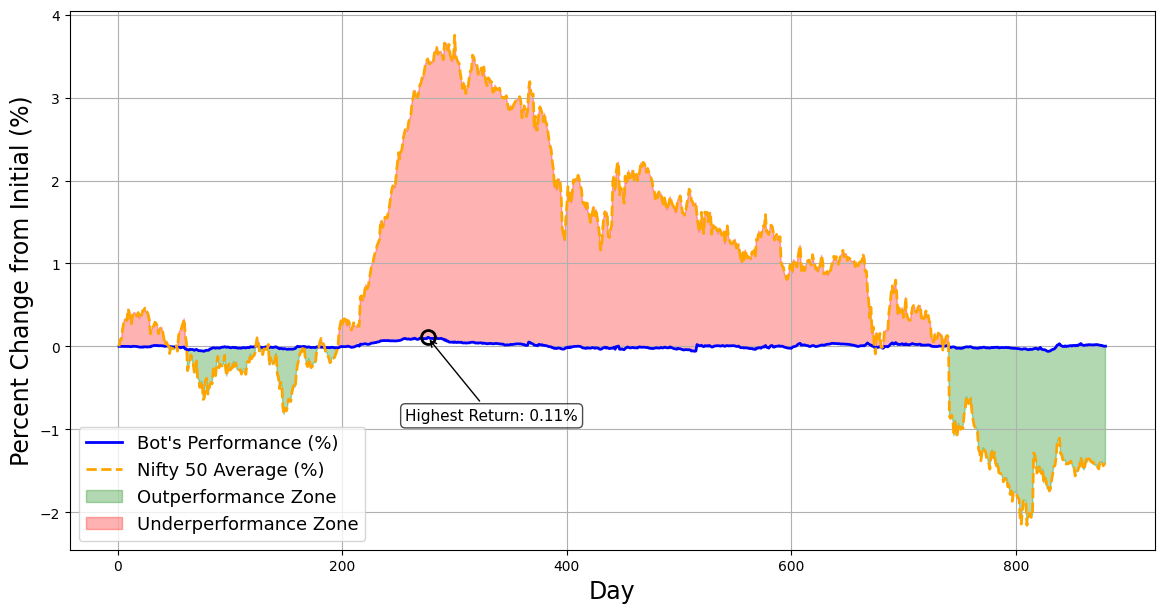

Performance plot successfully saved as 'portfolio_vs_nifty_comparison.png'


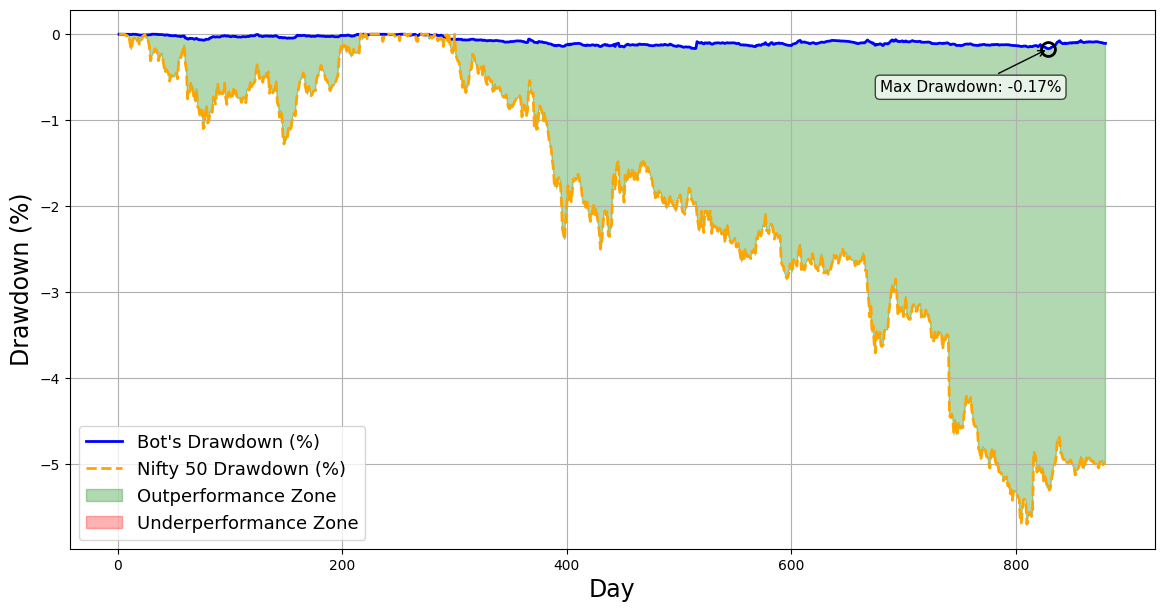

Drawdown plot successfully saved as 'bot_vs_nifty_drawdown.png'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

combined_portfolio_df = pd.concat(portfolio_df_list, axis=1)

if combined_portfolio_df.index.tz is not None:
    combined_portfolio_df.index = combined_portfolio_df.index.tz_localize(None)

portfolio_cols = [col for col in combined_portfolio_df.columns if col.startswith('Portfolio_')]
combined_portfolio_df['Average_Portfolio'] = combined_portfolio_df[portfolio_cols].mean(axis=1)

close_dfs = []
for ticker, df in all_data.items():
    if not pd.api.types.is_datetime64_any_dtype(df['time']):
        df['time'] = pd.to_datetime(df['time'])
    if df['time'].dt.tz is not None:
        df['time'] = df['time'].dt.tz_localize(None)
    
    df.set_index('time', inplace=True, drop=False)
    close_dfs.append(df[['Close']].rename(columns={'Close': ticker}))

combined_closes = pd.concat(close_dfs, axis=1).sort_index().ffill().bfill()
combined_closes['Nifty_Average'] = combined_closes.mean(axis=1)

if combined_closes.index.tz is not None:
    combined_closes.index = combined_closes.index.tz_localize(None)

aligned_df = pd.DataFrame({
    'time':             np.array(combined_closes.index)[-combined_portfolio_df['Average_Portfolio'].size:], 
    'Average_Portfolio': np.array(combined_portfolio_df['Average_Portfolio'])[-combined_portfolio_df['Average_Portfolio'].size:], 
    'Nifty_Average':    np.array(combined_closes['Nifty_Average'])[-combined_portfolio_df['Average_Portfolio'].size:]
})

initial_portfolio_value = 10000
initial_nifty_value     = aligned_df['Nifty_Average'].iloc[0]

bot_percent_change = (
    (aligned_df['Average_Portfolio'] - initial_portfolio_value) 
    / initial_portfolio_value
) * 100

nifty_percent_change = (
    (aligned_df['Nifty_Average'] - initial_nifty_value) 
    / initial_nifty_value
) * 100

outperformance_mask   = bot_percent_change > nifty_percent_change
underperformance_mask = ~outperformance_mask

plt.figure(figsize=(14, 7))

days = np.arange(1, len(aligned_df) + 1)

plt.plot(days, bot_percent_change, 
         label="Bot's Performance (%)", 
         color="blue",   
         linestyle="-", 
         linewidth=2)

plt.plot(days, nifty_percent_change, 
         label="Nifty 50 Average (%)", 
         color="orange",   
         linestyle="--", 
         linewidth=2)

plt.fill_between(days,
                 nifty_percent_change, 
                 bot_percent_change,
                 where=outperformance_mask,
                 color="green",
                 alpha=0.3,
                 interpolate=True,
                 label="Outperformance Zone")

plt.fill_between(days,
                 nifty_percent_change, 
                 bot_percent_change,
                 where=underperformance_mask,
                 color="red",
                 alpha=0.3,
                 interpolate=True,
                 label="Underperformance Zone")

max_return      = bot_percent_change.max()
max_return_day  = bot_percent_change.idxmax()  
highest_x_value = days[max_return_day]

plt.plot(highest_x_value, max_return, 
         marker='o', 
         markersize=10, 
         markerfacecolor='none',
         markeredgecolor='black', 
         markeredgewidth=2)

plt.annotate(
    f"Highest Return: {max_return:.2f}%",
    xy=(highest_x_value, max_return),
    xytext=(highest_x_value - 20, max_return - 1),
    fontsize=11,
    arrowprops=dict(arrowstyle='->', color='black'),
    bbox=dict(boxstyle="round", fc="white", ec="black", alpha=0.7)
)

plt.xlabel("Day", fontsize=17)
plt.ylabel("Percent Change from Initial (%)", fontsize=17)
plt.legend(fontsize=13, loc='lower left')
plt.grid(True)

perf_image_path = "portfolio_vs_nifty_comparison.png"
plt.savefig(perf_image_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Performance plot successfully saved as '{perf_image_path}'")

bot_values   = aligned_df['Average_Portfolio']
nifty_values = aligned_df['Nifty_Average']

bot_cummax   = bot_values.cummax()
nifty_cummax = nifty_values.cummax()

bot_drawdown   = (bot_values / bot_cummax - 1) * 100  # in %
nifty_drawdown = (nifty_values / nifty_cummax - 1) * 100

bot_drawdown   = bot_drawdown.iloc[-combined_portfolio_df['Average_Portfolio'].size:]
nifty_drawdown = nifty_drawdown.iloc[-combined_portfolio_df['Average_Portfolio'].size:]

drawdown_outperform_mask   = bot_drawdown > nifty_drawdown
drawdown_underperform_mask = ~drawdown_outperform_mask

plt.figure(figsize=(14, 7))

plt.plot(days, bot_drawdown, 
         label="Bot's Drawdown (%)", 
         color="blue",  
         linestyle="-", 
         linewidth=2)

plt.plot(days, nifty_drawdown, 
         label="Nifty 50 Drawdown (%)", 
         color="orange",  
         linestyle="--", 
         linewidth=2)

plt.fill_between(days, 
                 nifty_drawdown, 
                 bot_drawdown,
                 where=drawdown_outperform_mask,
                 color="green",
                 alpha=0.3,
                 interpolate=True,
                 label="Outperformance Zone")

plt.fill_between(days, 
                 nifty_drawdown, 
                 bot_drawdown,
                 where=drawdown_underperform_mask,
                 color="red",
                 alpha=0.3,
                 interpolate=True,
                 label="Underperformance Zone")

bot_max_drawdown = bot_drawdown.min()
bot_max_dd_day   = bot_drawdown.idxmin()
bot_dd_x_value   = np.where(bot_drawdown.index == bot_max_dd_day)[0][0] + 1  

plt.plot(bot_dd_x_value, bot_max_drawdown,
         marker='o',
         markersize=10,
         markerfacecolor='none',
         markeredgecolor='black',
         markeredgewidth=2)

plt.annotate(
    f"Max Drawdown: {bot_max_drawdown:.2f}%",
    xy=(bot_dd_x_value, bot_max_drawdown),
    xytext=(bot_dd_x_value - 150, bot_max_drawdown - 0.5),
    fontsize=11,
    arrowprops=dict(arrowstyle='->', color='black'),
    bbox=dict(boxstyle="round", fc="white", ec="black", alpha=0.7)
)

plt.xlabel("Day", fontsize=17)
plt.ylabel("Drawdown (%)", fontsize=17)
plt.legend(fontsize=13, loc='lower left')
plt.grid(True)

drawdown_image_path = "bot_vs_nifty_drawdown.png"
plt.savefig(drawdown_image_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Drawdown plot successfully saved as '{drawdown_image_path}'")
